In [6]:
import sys
cwd = "/Users/jordydikkers/Documents/repos/machi-koro-ai"
sys.path.append(cwd)
import os
os.chdir(cwd)

from mcts_agent import PVNet, HDF5DataLoader
import h5py
import torch
from env_machi_koro_2 import GymMachiKoro2

In [102]:
h5f_path = "checkpoints/2025-01-20 20:32:40.316970/buffers.h5"

In [103]:
h5f = h5py.File(h5f_path, "r")

In [101]:
h5f.close()

In [3]:
def explore_hdf5_structure(h5_file, group=None, indent=0):
    """
    Recursively explores the group structure of an HDF5 file and prints the number of rows or elements in datasets.
    
    Parameters:
    - h5_file: h5py File object
    - group: Current group or dataset (None starts from the root group)
    - indent: Current indentation level for pretty printing
    """
    if group is None:
        group = h5_file  # Start from the root group
    
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):  # If it's a group
            print(" " * indent + f"Group: {key}")
            explore_hdf5_structure(h5_file, item, indent + 4)
        elif isinstance(item, h5py.Dataset):  # If it's a dataset
            shape = item.shape  # Get the shape of the dataset
            num_rows = shape[0] if len(shape) > 0 else 0  # Number of rows if applicable
            print(" " * indent + f"Dataset: {key}, Rows: {num_rows}, Shape: {shape}")

In [6]:
h5f["train"]["iteration_0"]

<HDF5 group "/train/iteration_0" (1400 members)>

In [4]:
explore_hdf5_structure(h5f)

Dataset: VDS_train_0, Rows: 8818, Shape: (8818, 256)
Dataset: VDS_val_0, Rows: 2247, Shape: (2247, 256)
Group: train
    Group: iteration_0
        Dataset: game_1, Rows: 3, Shape: (3, 517)
        Dataset: game_10, Rows: 6, Shape: (6, 517)
        Dataset: game_100, Rows: 6, Shape: (6, 517)
        Dataset: game_1000, Rows: 10, Shape: (10, 517)
        Dataset: game_1001, Rows: 3, Shape: (3, 517)
        Dataset: game_1002, Rows: 10, Shape: (10, 517)
        Dataset: game_1004, Rows: 5, Shape: (5, 517)
        Dataset: game_1007, Rows: 5, Shape: (5, 517)
        Dataset: game_1008, Rows: 6, Shape: (6, 517)
        Dataset: game_1009, Rows: 6, Shape: (6, 517)
        Dataset: game_101, Rows: 2, Shape: (2, 517)
        Dataset: game_1010, Rows: 6, Shape: (6, 517)
        Dataset: game_1013, Rows: 5, Shape: (5, 517)
        Dataset: game_1015, Rows: 8, Shape: (8, 517)
        Dataset: game_1016, Rows: 6, Shape: (6, 517)
        Dataset: game_1017, Rows: 5, Shape: (5, 517)
        Dataset

In [96]:
CARD_INFO_PATH = "card_info_machi_koro_2_quick_game.yaml"


env = GymMachiKoro2(n_players=2, card_info_path=CARD_INFO_PATH)

pvnet = PVNet(env=env)
pvnet.load("checkpoints/2025-01-20 20:32:40.316970/model_0.pt")

In [13]:
data_manager = HDF5DataLoader(h5f_path, subset_rules={"iteration_0": 1.0}, chunk_size=64e5)
train_loader, val_loader = data_manager.get_dataloaders()

In [97]:
obs_col_indices = [i for i, col in enumerate(h5f.attrs["columns"]) if col.startswith("obs")]
probs_col_indices = [i for i, col in enumerate(h5f.attrs["columns"]) if col.startswith("prob")]

In [107]:
init_obs = h5f["train"]["iteration_0"]["game_0"][0, obs_col_indices]
init_prob = h5f["train"]["iteration_0"]["game_0"][0, probs_col_indices]

In [108]:
init_prob

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01      , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99000001,
       0.        ])

In [109]:
pred = pvnet.predict(init_obs)

In [110]:
pred[0]

array([8.6156413e-04, 5.7223614e-04, 1.7827109e-03, 7.8312624e-03,
       5.5750582e-04, 6.8426789e-03, 7.1653299e-04, 8.1154844e-03,
       1.5485676e-03, 8.0379477e-04, 7.0852693e-04, 5.5966998e-04,
       5.4197758e-04, 9.3664452e-03, 1.7476199e-03, 1.7362903e-03,
       5.7090906e-04, 6.5565348e-04, 1.8601542e-03, 5.8300490e-04,
       1.4760086e-03, 5.4862280e-04, 7.6736091e-04, 5.6737859e-04,
       5.6484091e-04, 5.3171534e-04, 6.7739969e-04, 7.8870896e-03,
       6.5215598e-03, 5.6923082e-04, 6.6835084e-03, 5.5992941e-04,
       5.7047338e-04, 7.1993965e-04, 8.6233352e-04, 5.5757444e-04,
       5.5454165e-04, 5.9645745e-04, 6.5068022e-04, 9.1812491e-01,
       2.0458861e-03], dtype=float32)

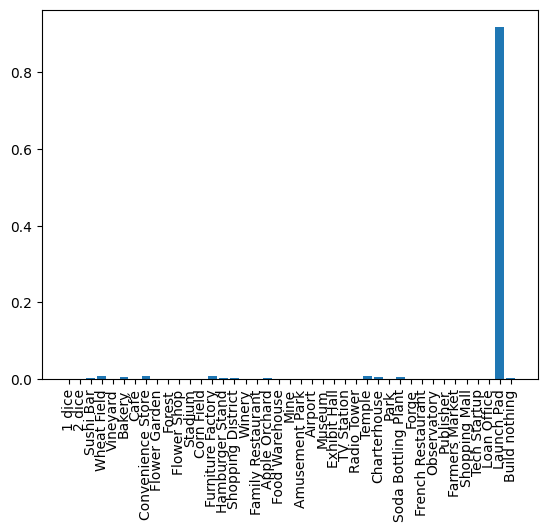

In [111]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar([env._action_idx_to_str[idx] for idx in np.arange(len(pred[0]))], pred[0])
plt.xticks(rotation=90)
plt.show()

In [47]:
env._action_idx_to_str[0]

'1 dice'

In [95]:
CARD_INFO_PATH = "card_info_machi_koro_2_quick_game.yaml"

env = GymMachiKoro2(n_players=2, card_info_path=CARD_INFO_PATH)

env.reset()
state = env.state_dict()
state["player_info"]["player 0"]["coins"] = 30
state["player_info"]["player 1"]["coins"] = 30
# state["player_info"]["player 0"]["cards"]["Forge"] = 1
# state["player_info"]["player 0"]["cards"]["Park"] = 1
# state["player_info"]["player 1"]["cards"]["Forge"] = 1
# state["player_info"]["player 1"]["cards"]["Park"] = 1
state["marketplace"]["landmark"]["pos_0"]["card"] = "Launch Pad"
state["marketplace"]["landmark"]["pos_1"]["card"] = "Loan Office"
state["marketplace"]["landmark"]["pos_2"]["card"] = "Soda Bottling Plant"
state["marketplace"]["landmark"]["pos_3"]["card"] = "Charterhouse"
state["marketplace"]["landmark"]["pos_4"]["card"] = "Temple"
env.set_state(env.state_dict_to_array(state))

# GAME_START_STATE = env.state_dict_to_array(state)
# next_obs, reward, done, truncated, info = env.step(33)
env.step(39)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  2,  2, -1, -1,  2,  3, -1,  3,  3, -1,  4, -1,  4,  4,
         4,  5,  5,  5,  5,  5,  6,  6,  6,  6, -1,  7, -1,  7,  7,  7,  8,
         8,  8,  9, -1,  9, 10, 10, -1, 10, 10, 11, 11, -1, 12, 12, 12, 12,
        12, 13, 13, 13, 14, 14, 14, 15, -1, 15, 15, 15, 16, 16, 16, 16, 16,
        17, 17, 17, 18, -1, 18, 18, 18, 19, 20, -1, 22, 23, -1, 25, 26, 27,
        28, 29, -1, 31, -1, -1, -1, 35, 36, 37,  4,  1,  6,  1,  7,  1,  2,
         2,  3,  2, 18,  1, 15,  1, 10,  1, 11,  1,  9,  1, 21,  1, 36,  1,
        28,  1, 26,  1, 25,  1,  0,  1,  0,  3]),
 1,
 True,
 False,
 {'winning_player_i

In [94]:
env._env.player_icon_count("player 1", "Landmark")

2

In [78]:
env._action_str_to_idx["Observatory"]

33

In [77]:
state["marketplace"]["landmark"]

{'pos_0': {'card': 'Observatory', 'count': 1},
 'pos_1': {'card': 'Loan Office', 'count': 1},
 'pos_2': {'card': 'Museum', 'count': 1},
 'pos_3': {'card': 'Forge', 'count': 1},
 'pos_4': {'card': 'Publisher', 'count': 1}}